In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

import numpy as np
import cv2
import matplotlib.pyplot as plt

In [2]:
DATA_DIR = './data/CamVid/CamVid'

# load repo with data if it is not exists
if not os.path.exists(DATA_DIR):
    print('Loading data...')
    os.system('git clone https://github.com/alexgkendall/SegNet-Tutorial ./data')
    print('Done!')

In [3]:
x_train_dir = os.path.join(DATA_DIR, 'train')
y_train_dir = os.path.join(DATA_DIR, 'trainannot')

x_valid_dir = os.path.join(DATA_DIR, 'val')
y_valid_dir = os.path.join(DATA_DIR, 'valannot')

x_test_dir = os.path.join(DATA_DIR, 'test')
y_test_dir = os.path.join(DATA_DIR, 'testannot')

In [4]:
# helper function for data visualization
def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
    plt.show()

# Dataloader

In [5]:
from torch.utils.data import DataLoader
from torch.utils.data import Dataset as BaseDataset

In [6]:
class Dataset(BaseDataset):
    """CamVid Dataset. Read images, apply augmentation and preprocessing transformations.
    
    Args:
        images_dir (str): path to images folder
        masks_dir (str): path to segmentation masks folder
        class_values (list): values of classes to extract from segmentation mask
        augmentation (albumentations.Compose): data transfromation pipeline 
            (e.g. flip, scale, etc.)
        preprocessing (albumentations.Compose): data preprocessing 
            (e.g. noralization, shape manipulation, etc.)
    
    """
    
    CLASSES = ['sky', 'building', 'pole', 'road', 'pavement', 
               'tree', 'signsymbol', 'fence', 'car', 
               'pedestrian', 'bicyclist', 'unlabelled']
    
    def __init__(
            self, 
            images_dir, 
            masks_dir, 
            classes=None, 
            augmentation=None, 
            preprocessing=None,
    ):
        self.ids = os.listdir(images_dir)
        self.images_fps = [os.path.join(images_dir, image_id) for image_id in self.ids]
        self.masks_fps = [os.path.join(masks_dir, image_id) for image_id in self.ids]
        
        # convert str names to class values on masks
        self.class_values = [self.CLASSES.index(cls.lower()) for cls in classes]
        
        self.augmentation = augmentation
        self.preprocessing = preprocessing
    
    def __getitem__(self, i):
        
        # read data
        image = cv2.imread(self.images_fps[i])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.masks_fps[i], 0)
        
        # extract certain classes from mask (e.g. cars)
        masks = [(mask == v) for v in self.class_values]
        mask = np.stack(masks, axis=-1).astype('float')
        
        # apply augmentations
        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
        
        # apply preprocessing
        if self.preprocessing:
            sample = self.preprocessing(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
            
        return image, mask
        
    def __len__(self):
        return len(self.ids)

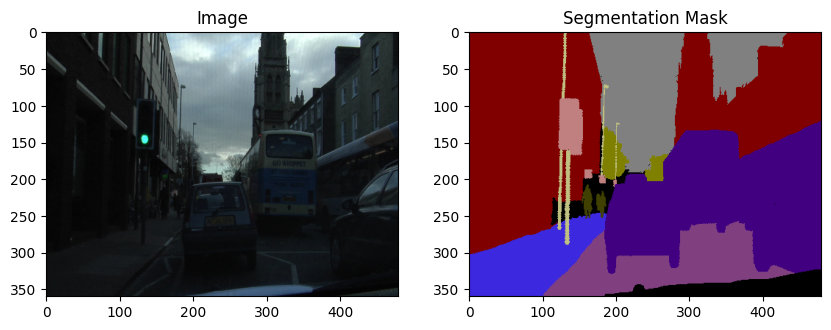

In [27]:
    
CLASSES = ['sky', 'building', 'pole', 'road', 'pavement', 
            'tree', 'signsymbol', 'fence', 'car', 
            'pedestrian', 'bicyclist', 'unlabelled']

COLOR_MAP = {
    'sky': [128, 128, 128],
    'building': [128, 0, 0],
    'pole': [192, 192, 128],
    'road': [128, 64, 128],
    'pavement': [60, 40, 222],
    'tree': [128, 128, 0],
    'signsymbol': [192, 128, 128],
    'fence': [64, 64, 128],
    'car': [64, 0, 128],
    'pedestrian': [64, 64, 0],
    'bicyclist': [0, 128, 192],
    'unlabelled': [0, 0, 0]
}


def mask_to_rgb(mask):
    """
    Convert one-hot encoded mask to RGB image using the color map.
    """
    # Create an empty RGB image
    rgb_mask = np.zeros(mask.shape[:-1] + (3,), dtype=np.uint8)
    
    # Iterate over channels and apply colors
    for i, class_name in enumerate(CLASSES):
        rgb_mask[mask[..., i] == 1] = COLOR_MAP[class_name]
    
    return rgb_mask

# Lets look at data we have

dataset = Dataset(x_train_dir, y_train_dir, classes=CLASSES)

image, mask = dataset[0] # get some sample

# Convert mask to RGB
rgb_mask = mask_to_rgb(mask)

# Visualization
plt.figure(figsize=(10,5))
plt.subplot(1, 2, 1)
plt.imshow(image)
plt.title('Image')

plt.subplot(1, 2, 2)
plt.imshow(rgb_mask)
plt.title('Segmentation Mask')
plt.show()

## Augmentations

In [8]:
import albumentations as albu

In [9]:
def get_training_augmentation():
    train_transform = [

        albu.HorizontalFlip(p=0.5),

        albu.ShiftScaleRotate(scale_limit=0.5, rotate_limit=0, shift_limit=0.1, p=1, border_mode=0),

        albu.PadIfNeeded(min_height=320, min_width=320, always_apply=True, border_mode=0),
        albu.RandomCrop(height=320, width=320, always_apply=True),

        albu.IAAAdditiveGaussianNoise(p=0.2),
        albu.IAAPerspective(p=0.5),

        albu.OneOf(
            [
                albu.CLAHE(p=1),
                albu.RandomBrightness(p=1),
                albu.RandomGamma(p=1),
            ],
            p=0.9,
        ),

        albu.OneOf(
            [
                albu.IAASharpen(p=1),
                albu.Blur(blur_limit=3, p=1),
                albu.MotionBlur(blur_limit=3, p=1),
            ],
            p=0.9,
        ),

        albu.OneOf(
            [
                albu.RandomContrast(p=1),
                albu.HueSaturationValue(p=1),
            ],
            p=0.9,
        ),
    ]
    return albu.Compose(train_transform)


def get_validation_augmentation():
    """Add paddings to make image shape divisible by 32"""
    test_transform = [
        albu.PadIfNeeded(384, 480)
    ]
    return albu.Compose(test_transform)


def to_tensor(x, **kwargs):
    return x.transpose(2, 0, 1).astype('float32')


def get_preprocessing(preprocessing_fn):
    """Construct preprocessing transform
    
    Args:
        preprocessing_fn (callbale): data normalization function 
            (can be specific for each pretrained neural network)
    Return:
        transform: albumentations.Compose
    
    """
    
    _transform = [
        albu.Lambda(image=preprocessing_fn),
        albu.Lambda(image=to_tensor, mask=to_tensor),
    ]
    return albu.Compose(_transform)

c:\Users\appel\anaconda3\envs\ML\lib\site-packages\albumentations\imgaug\transforms.py:261: FutureWarning: IAAAdditiveGaussianNoise is deprecated. Please use GaussNoise instead
  warnings.warn("IAAAdditiveGaussianNoise is deprecated. Please use GaussNoise instead", FutureWarning)
c:\Users\appel\anaconda3\envs\ML\lib\site-packages\albumentations\imgaug\transforms.py:384: FutureWarning: This IAAPerspective is deprecated. Please use Perspective instead
  warnings.warn("This IAAPerspective is deprecated. Please use Perspective instead", FutureWarning)
c:\Users\appel\anaconda3\envs\ML\lib\site-packages\albumentations\augmentations\transforms.py:1258: FutureWarning: This class has been deprecated. Please use RandomBrightnessContrast
  warnings.warn(
c:\Users\appel\anaconda3\envs\ML\lib\site-packages\albumentations\imgaug\transforms.py:231: FutureWarning: IAASharpen is deprecated. Please use Sharpen instead
  warnings.warn("IAASharpen is deprecated. Please use Sharpen instead", FutureWarning)

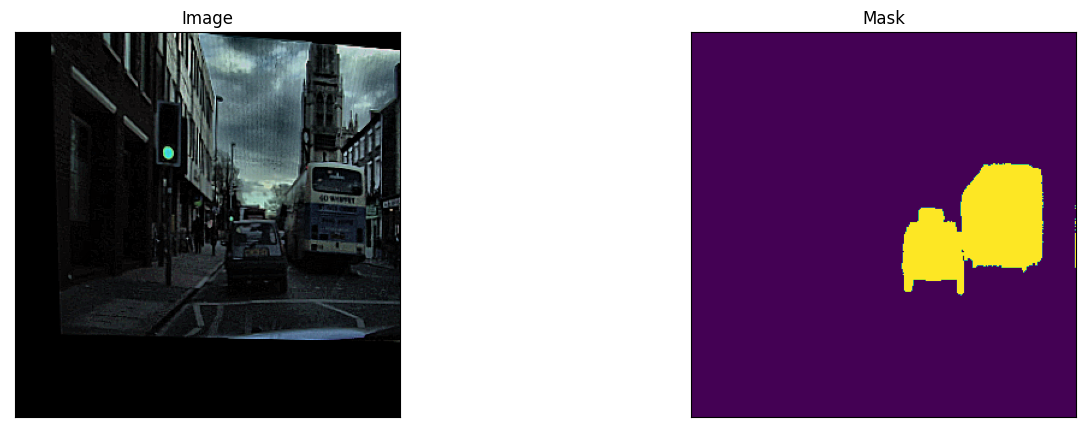

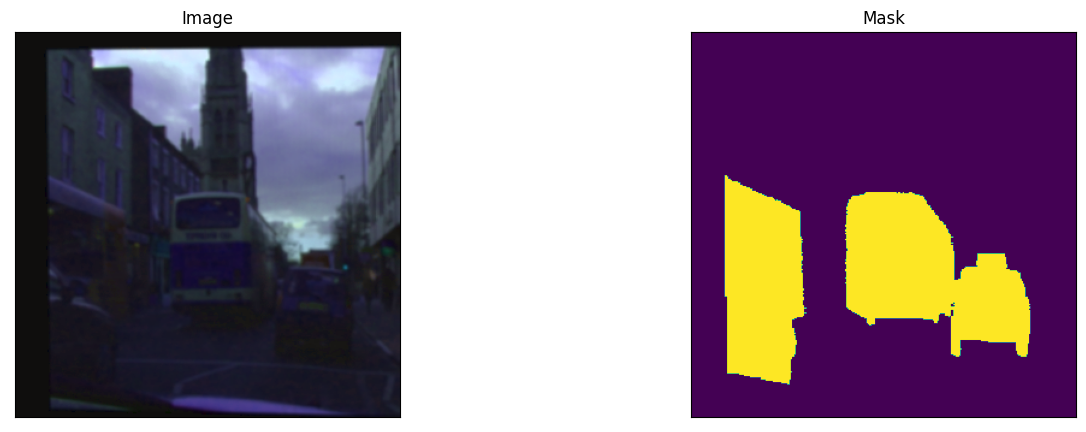

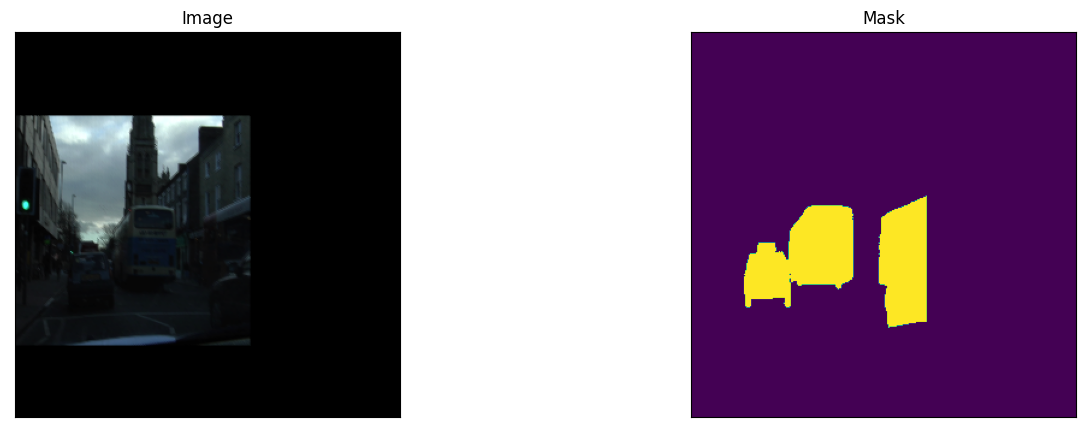

In [10]:


#### Visualize resulted augmented images and masks

augmented_dataset = Dataset(
    x_train_dir, 
    y_train_dir, 
    augmentation=get_training_augmentation(), 
    classes=['car'],
)

# same image with different random transforms
for i in range(3):
    image, mask = augmented_dataset[1]
    visualize(image=image, mask=mask.squeeze(-1))



# Create model and train